# DCBC model evaluation

In [1]:
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import os

In [111]:
Data = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_atlas_existing_dist-40.tsv', sep='\t')

In [112]:
Data = Data[Data['test_data'] != 'HCP']
Data = Data.drop(columns=['space'])
Data.head()

,atlas_name,K,subj_num,dcbc_group,test_data
0,NettekovenAsym32,31,0,0.083966,MDTB
1,NettekovenAsym32,31,1,0.069000,MDTB
2,NettekovenAsym32,31,2,0.049437,MDTB
3,NettekovenAsym32,31,3,0.185517,MDTB
4,NettekovenAsym32,31,4,0.080753,MDTB


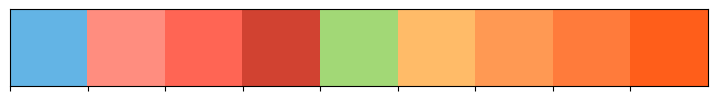

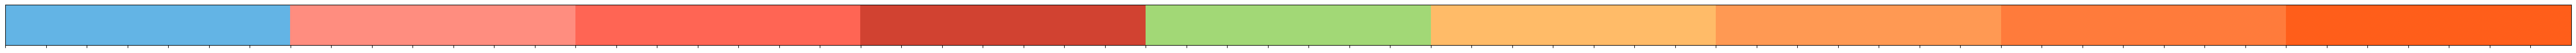

In [113]:
atlas_order = ['Anatom', 'Buckner7', 'Ji10', 'Buckner17', 'MDTB10', 'NettekovenSym32', 'NettekovenAsym32', 'NettekovenSym68', 'NettekovenAsym68']
# Order atlas_name column by atlas_order
Data['atlas_name'] = pd.Categorical(Data['atlas_name'], atlas_order)

# -- Colour palette --
# Define the base color palette with 9 colors, grouped by atlas type:
# anatomical (blue), resting-state (3 shades of red), MDTB (green), and Nettekoven (4 shades of orange)
base_palette = [
    "#63B4E5",  # Light Blue
    "#FF8D7F",  # Light Red
    "#FF6554",  # Medium Red
    "#D14231",  # Dark Red
    "#A2D876",  # Light Green
    "#FFBB68",  # Light Orange
    "#FF9953",  # Medium Orange
    "#FF7B3B",  # Dark Orange
    "#FF5E1A"   # Deep Orange
]

# Create a cpalette
color_palette = sb.color_palette(base_palette)

# Create a colour palette with test_data length entries
color_palette_hue = [col for color in base_palette for col in [color] * len(Data['test_data'].unique())]
color_palette_hue = sb.color_palette(color_palette_hue)

# Display the color palette
sb.palplot(color_palette)
sb.palplot(color_palette_hue)

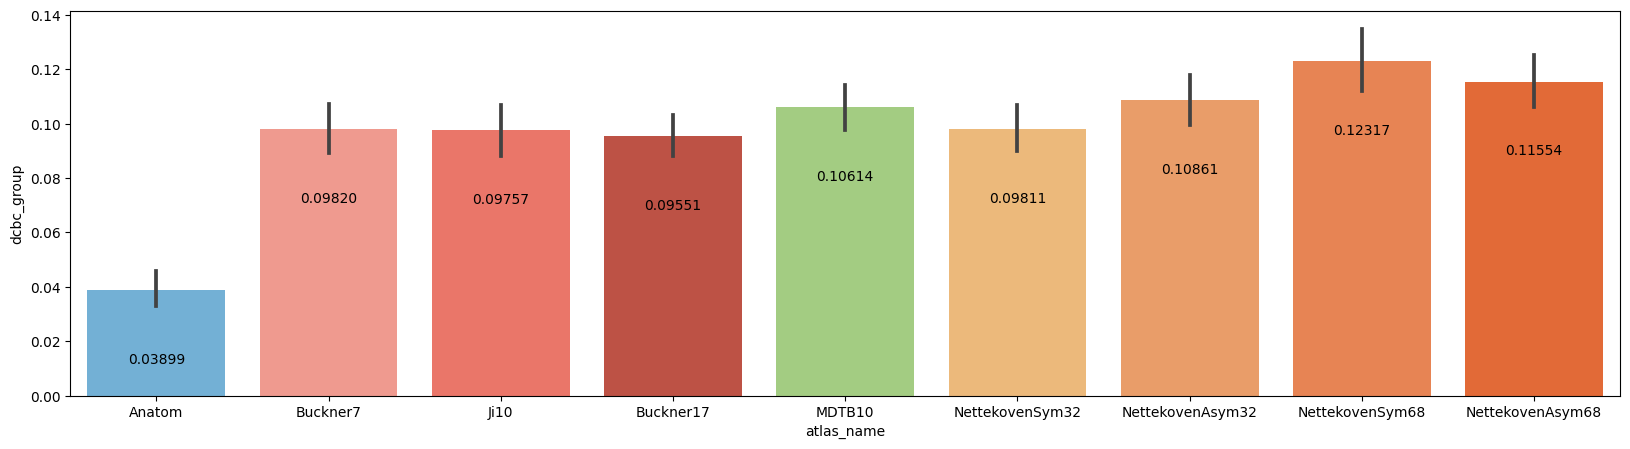

In [114]:
plt.figure(figsize=(20, 5))
ax = sb.barplot(data=Data, x='atlas_name', y='dcbc_group', palette=color_palette)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.5f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, -50), textcoords='offset points')



In [115]:
Data.drop(columns=['test_data']).groupby('atlas_name').mean().reset_index().sort_values(by='dcbc_group', ascending=False)

,atlas_name,K,subj_num,dcbc_group
7,NettekovenSym68,61.0,10.801802,0.123167
8,NettekovenAsym68,64.0,10.801802,0.115538
6,NettekovenAsym32,31.0,10.801802,0.108615
4,MDTB10,149.0,10.801802,0.106141
1,Buckner7,83.0,10.801802,0.098202
5,NettekovenSym32,31.0,10.801802,0.098108
2,Ji10,573.0,10.801802,0.097565
3,Buckner17,149.0,10.801802,0.095514
0,Anatom,44.0,10.801802,0.038991


<Axes: xlabel='atlas_name', ylabel='dcbc_group'>

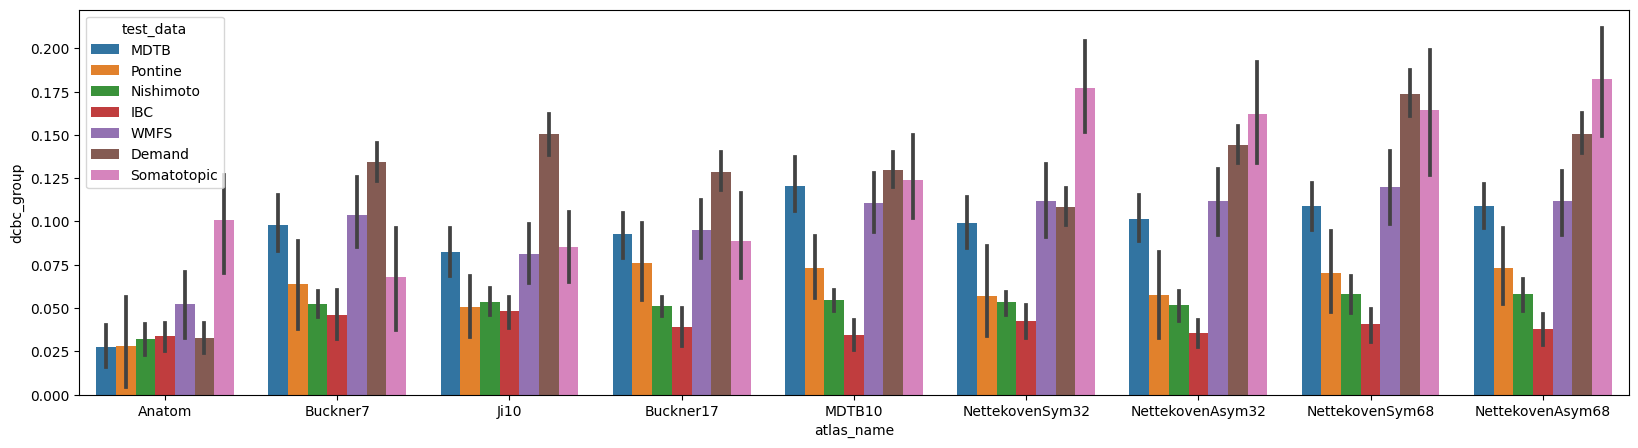

In [116]:
# repeat each entry of times the number of test_data entries 
plt.figure(figsize=(20, 5))
sb.barplot(data=Data, x='atlas_name', y='dcbc_group', hue='test_data')



# Average within dataset

In [117]:
Data_mean = Data.groupby(['atlas_name', 'test_data']).mean().reset_index()
Data_mean.head()


,atlas_name,test_data,K,subj_num,dcbc_group
0,Anatom,Demand,44.0,18.0,0.032431
1,Anatom,IBC,44.0,5.5,0.034078
2,Anatom,MDTB,44.0,11.5,0.027264
3,Anatom,Nishimoto,44.0,2.5,0.031941
4,Anatom,Pontine,44.0,3.5,0.028204


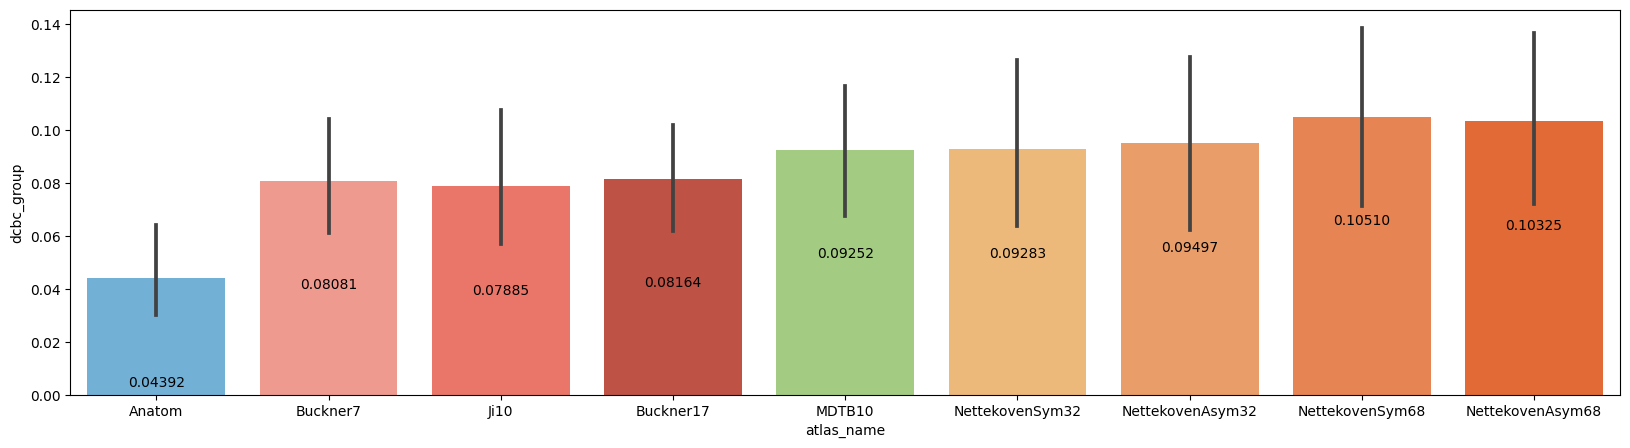

In [118]:
plt.figure(figsize=(20, 5))
ax = sb.barplot(data=Data_mean, x='atlas_name', y='dcbc_group', palette=color_palette)
# Print the mean value of each bar above the bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.5f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, -75), textcoords='offset points')

In [119]:
Data_mean.drop(columns=['test_data']).groupby('atlas_name').mean().reset_index().sort_values(by='dcbc_group', ascending=False)



,atlas_name,K,subj_num,dcbc_group
7,NettekovenSym68,61.0,7.428571,0.105095
8,NettekovenAsym68,64.0,7.428571,0.103250
6,NettekovenAsym32,31.0,7.428571,0.094975
5,NettekovenSym32,31.0,7.428571,0.092830
4,MDTB10,149.0,7.428571,0.092517
3,Buckner17,149.0,7.428571,0.081645
1,Buckner7,83.0,7.428571,0.080810
2,Ji10,573.0,7.428571,0.078847
0,Anatom,44.0,7.428571,0.043920


# Statistics

In [120]:
def print_ttest(x,y, paired=False):
    
    if paired:
        result = stats.ttest_rel(x,y)
        df= len(x) - 1
    else:
        result = stats.ttest_ind(x,y)
        df= len(x) + len(y) - 2
    # Print result formatted with p-value rounded to 5th decimal (df, p-value, t-value)
    print(f't({df}) = {result[0]:.3f}, p = {result[1]:.5f}')
    print(f'x = {np.mean(x):.5f} +/- {np.std(x):.3f}, y = {np.mean(y):.5f} +/- {np.std(y):.3f}')

## MDTB 10 vs Nettekoven atlasses

### paired t-test between each subject's DCBC for MDTB10 and Nettekoven atlas

In [121]:
for new_atlas in ['NettekovenSym32', 'NettekovenAsym32', 'NettekovenSym68', 'NettekovenAsym68']:
    x = Data[(Data['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data[(Data['atlas_name'] == 'MDTB10')]['dcbc_group']
    print(f'\n{new_atlas} vs MDTB10')
    print_ttest(x,y, paired=True)

    


NettekovenSym32 vs MDTB10
t(110) = -2.657, p = 0.00907
x = 0.09811 +/- 0.047, y = 0.10614 +/- 0.046

NettekovenAsym32 vs MDTB10
t(110) = 1.072, p = 0.28590
x = 0.10861 +/- 0.052, y = 0.10614 +/- 0.046

NettekovenSym68 vs MDTB10
t(110) = 5.364, p = 0.00000
x = 0.12317 +/- 0.060, y = 0.10614 +/- 0.046

NettekovenAsym68 vs MDTB10
t(110) = 3.545, p = 0.00058
x = 0.11554 +/- 0.053, y = 0.10614 +/- 0.046


### independent t-test between each test dataset's average DCBC for MDTB10 and Nettekoven atlas

In [122]:
for new_atlas in ['NettekovenSym32', 'NettekovenAsym32', 'NettekovenSym68', 'NettekovenAsym68']:
    x = Data_mean[(Data_mean['atlas_name'] == new_atlas)]['dcbc_group']
    y = Data_mean[(Data_mean['atlas_name'] == 'MDTB10')]['dcbc_group']
    print(f'\n{new_atlas} vs MDTB10')
    print_ttest(x,y, paired=False)

    


NettekovenSym32 vs MDTB10
t(12) = 0.014, p = 0.98925
x = 0.09283 +/- 0.043, y = 0.09252 +/- 0.035

NettekovenAsym32 vs MDTB10
t(12) = 0.106, p = 0.91753
x = 0.09497 +/- 0.045, y = 0.09252 +/- 0.035

NettekovenSym68 vs MDTB10
t(12) = 0.519, p = 0.61335
x = 0.10510 +/- 0.048, y = 0.09252 +/- 0.035

NettekovenAsym68 vs MDTB10
t(12) = 0.445, p = 0.66405
x = 0.10325 +/- 0.047, y = 0.09252 +/- 0.035
